In [111]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [112]:
# 分類器
def build_classifier(data, labels, n_classes=2):
    data_shape = data.get_shape().as_list() # TensorshapeクラスのObject(テンソルの形状)
    
    weights = tf.get_variable(name='weights',shape=(data_shape[1], n_classes),dtype=tf.float32)
    bias = tf.get_variable(name='bias', initializer=tf.zeros(shape=n_classes))
    print(weights)
    print(bias)
    
    # tf.matmul:行列積
    # tf.add:総和
    logits = tf.add(tf.matmul(data, weights), bias, name='logits')
    print(logits)
    return logits, tf.nn.softmax(logits) # 総出力 & SoftMax(総出力)

# ジェネレータ
def build_generator(data, n_hidden):
    data_shape = data.get_shape().as_list()
    
    # tf.random_normal:正規分布の乱数生成
    # tf.zeros:0の配列生成
    w1 = tf.Variable(tf.random_normal(shape=(data_shape[1], n_hidden)),name='w1')
    b1 = tf.Variable(tf.zeros(shape=n_hidden), name='b1')
    hidden = tf.add(tf.matmul(data, w1), b1, name='hidden_pre-activation')
    hidden = tf.nn.relu(hidden, 'hidden_activation')
        
    w2 = tf.Variable(tf.random_normal(shape=(n_hidden, data_shape[1])),name='w2')
    b2 = tf.Variable(tf.zeros(shape=data_shape[1]),name='b2')
    output = tf.add(tf.matmul(hidden, w2), b2, name = 'output')
    
    return output, tf.nn.sigmoid(output)

# 計算グラフの構築
batch_size=64
g = tf.Graph()

with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100), dtype=tf.float32,name='tf_X')
    with tf.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X, n_hidden=50)
    
    with tf.variable_scope('classifier') as scope:
        cls_out1 = build_classifier(data=tf_X, labels=tf.ones(shape=batch_size))
        
        scope.reuse_variables() # 変数の共有
        cls_out2 = build_classifier(data=gen_out1[1],labels=tf.zeros(shape=batch_size))
        
        init_op = tf.global_variables_initializer()

<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier/logits:0", shape=(64, 2), dtype=float32)
<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier/logits_1:0", shape=(64, 2), dtype=float32)


In [113]:
g = tf.Graph()

with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100), dtype=tf.float32,name='tf_X')
    with tf.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X, n_hidden=50)
    
    with tf.variable_scope('classifier'):
        cls_out1 = build_classifier(data=tf_X, labels=tf.ones(shape=batch_size))
        
    with tf.variable_scope('classifier', reuse=True): # 変数の共有
        cls_out2 = build_classifier(data=gen_out1[1],labels=tf.zeros(shape=batch_size))
        
        init_op = tf.global_variables_initializer()

<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier/logits:0", shape=(64, 2), dtype=float32)
<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier_1/logits:0", shape=(64, 2), dtype=float32)


In [114]:
batch_size = 64
g = tf.Graph()

# build_generator

with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100), dtype=tf.float32,name='tf_X')
    
    # ジェネレータを構築
    with tf.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X, n_hidden=50)
    
    # 分類器を構築
    with tf.variable_scope('classifier') as scope:
        # tf_Xに対しての分類器
        cls_out1 = build_classifier(data=tf_X, labels=tf.ones(shape=batch_size))
        
        # 生成されたデータに対しての分類器
        scope.reuse_variables()
        cls_out2 = build_classifier(data=gen_out1[1], labels=tf.zeros(shape=batch_size))

<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier/logits:0", shape=(64, 2), dtype=float32)
<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier/logits_1:0", shape=(64, 2), dtype=float32)


In [115]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    file_writer=tf.summary.FileWriter(logdir='./logs/', graph=g)

In [116]:
# TensorBoardの起動
# AnacondaNavigator
# Environment->Prompt
# cd JupyterDirectory
# python -m tensorboard.main --logdir=./logs/ --host=127.0.0.1

# ここから記事用の素材作成

### MINSTのデータセットを弄ってみる

In [117]:
import struct
 
def load_mnist(path, kind):
    # ファイルのパスを設定
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind).replace('\\','/')
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind).replace('\\','/')
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784) # 正解データ数×784
        images = ((images / 255.) - .5) * 2  # -1~1の範囲で正規化
        #images = ((images / 255.) - .5) # -0.5~0.5の範囲で正規化
        #images = (images / 255.) # 0~1の範囲で正規化
 
    return images, labels

In [118]:
current_path = os.path.join(os.getcwd(),'mnist')
X_train, y_train = load_mnist(current_path, kind='train')
print('Rows: %d,  Columns: %d' %(X_train.shape[0], X_train.shape[1]))

Rows: 60000,  Columns: 784


In [119]:
X_test, y_test = load_mnist(current_path, kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


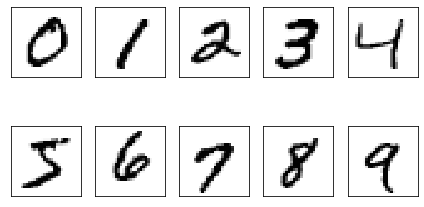

In [120]:
### せっかくなので可視化
# 縦横2×5で描写、sharex・shareyでx軸とy軸を同期
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
# forループ中でax[i]だけで描写できるようになる
ax = ax.flatten()

for i in range(10):
    # y_train(正解データ)が0～9のデータの0個目
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([]) #x軸を非表示
ax[0].set_yticks([]) #y軸を非表示
plt.tight_layout()   #レイアウトを調整してくれる
plt.show()

In [121]:
### 前処理
mean_vals = np.mean(X_train, axis=0) # 平均値
std_val = np.std(X_train) # 標準偏差

# 中心化
X_train_centered = (X_train - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

print(X_train_centered.shape, y_train.shape)
print(X_test_centered.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


### バッチジェネレーター

In [122]:
# データバッチ生成用のジェネレーター
def create_batch_generator(X, y, batch_size=128, shuffle=True):
    X_copy = np.array(X)
    y_copy = np.array(y)
    
    if shuffle:
        data = np.column_stack((X_copy, y_copy)) # X_copyとy_copyを列方向に結合
        np.random.shuffle(data)                  # ランダムにシャッフル
        X_copy = data[:, :-1]                    # X_copyを再度取得
        y_copy = data[:, -1].astype(int)         # y_copyを再度取得
        #print(data)
        #print(X_copy)
        #print(y_copy)
        
    for i in range(0, X.shape[0], batch_size):   # 0～X_行の数だけbatchsizeごとにiを取得
        yield (X_copy[i:i+batch_size, :], y_copy[i:i+batch_size]) 

### アルゴリズム

In [160]:
n_features = X_train_centered.shape[1] # 特徴量の数
n_classes = 10                         # 正解ラベルのユニーク数
random_seed = 123
np.random.seed(random_seed)

g = tf.Graph()

with g.as_default():
    tf.set_random_seed(random_seed)
    tf_x = tf.placeholder(dtype=tf.float32,shape=(None, n_features),name='tf_x')
    tf_y = tf.placeholder(dtype=tf.int32, shape=None, name='tf_y')
    
    # tf.one_hot:ワンホット表現に置き換える
    y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)
    
    # 隠れ層を定義
    '''
    input:インプットデータ
    units:隠れ層が有する層数
    activation:活性化に利用する関数
    '''
    h1 = tf.layers.dense(inputs=tf_x, units=50,activation=tf.tanh,name='layer1')
    h2 = tf.layers.dense(inputs=h1, units=50,activation=tf.tanh,name='layer2')
    logits = tf.layers.dense(inputs=h2, units=10,activation=None,name='layer3')
    
    # 出力層の出力を定義
    predictions = {
        'classes' : tf.argmax(logits, axis=1, name='predicted_classes'),  # 予測されたクラス
        'probabilities' : tf.nn.softmax(logits, name='softmax_tensor')    # 9クラスの確率
    }
    
    # コスト関数
    # onehot_labels:正解データ logits:予測結果
    # tf.losses.softmax_cross_entropy:ソフトマックス関数 + クロスエントロピー
    cost = tf.losses.softmax_cross_entropy(onehot_labels=y_onehot,logits=logits)
    
    # オプティマイザを作成
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001) # オプティマイザを定義(急速降下法)
    train_op = optimizer.minimize(loss=cost) # 実行用
    init_op = tf.global_variables_initializer() 

In [161]:
# TensorFlowのセッション開始
sess = tf.Session(graph=g)
sess.run(init_op)

# 10エポックのトレーニング
training_costs=[]
for epoch in range(1):
    training_loss=[]
    batch_generator=create_batch_generator(X_train_centered, y_train, batch_size=10)
    
    for batch_X, batch_y in batch_generator:
        feed={tf_x:batch_X, tf_y:batch_y}
        _, batch_cost = sess.run([train_op, cost], feed_dict=feed)
        training_costs.append(batch_cost)
        
    print(' -- Epoch %2d  Avg. Training Loss: %.4f' % (epoch+1, np.mean(training_costs)))

 -- Epoch  1  Avg. Training Loss: 0.8121


In [176]:
# テストデータセットで予測を行う
feed = {tf_x : X_test_centered}

# y_pred : 予測結果の数値(1×10000)
# prob   : 各テストデータにおける予測確率(10×10000)
y_pred, prob = sess.run([predictions['classes'],predictions['probabilities']], feed_dict=feed)
print('Test Accuracy: %.2f' % (100 * np.sum(y_pred == y_test)/y_test.shape[0]))

Test Accuracy: 88.95


In [177]:
# TensorBoardで可視化
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    file_writer=tf.summary.FileWriter(logdir='./test2/', graph=g)

In [ ]:
# TensorBoardの起動
# AnacondaNavigator
# Environment->Open Terminal
# cd JupyterDirectory
# python -m tensorboard.main --logdir=./logs/

In [180]:
# yieldってこんなやつ
def func(number):
    for i in range(0, 5):
        yield number + i
  
answer = func(2)
print(type(answer))
for ans_value in answer:
    print(ans_value)

<class 'generator'>
2
3
4
5
6
